In [1]:
import numpy as np
import pandas as pd
import bottleneck as bn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import kstest, spearmanr

In [2]:
raw_data = pd.read_csv('data.csv')
raw_data.head()

,ticker,date,last,volume
0,1332 JT,2013-01-04,169.0987,1464100
1,1332 JT,2013-01-07,166.3266,1783500
2,1332 JT,2013-01-08,166.3266,1759800
3,1332 JT,2013-01-09,165.4026,767800
4,1332 JT,2013-01-10,167.2507,1503100


## Data Exploration
1. transform raw data to rectangular data
2. check the number of missing values
3. check the position of missing values
4. check the distribution of daily return and log volume

In [3]:
print('The number of stocks:', np.unique(raw_data['ticker']).size)
print('The number of dates:', np.unique(raw_data['date']).size)

price = raw_data.pivot(index = 'date', columns = 'ticker', values = 'last').sort_index()
volume = raw_data.pivot(index = 'date', columns = 'ticker', values = 'volume').sort_index()

np.nansum(np.isnan(price) != np.isnan(volume))

The number of stocks: 248
The number of dates: 2005


0

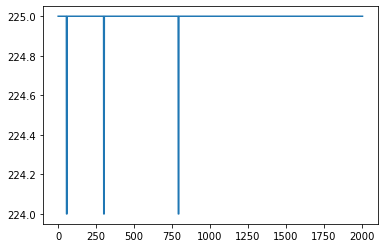

In [4]:
# check coverage
# plt.plot(np.nansum(np.isnan(price),axis=1)/price.shape[1])
plt.plot(np.nansum(~np.isnan(price),axis=1))
### 225 < 248

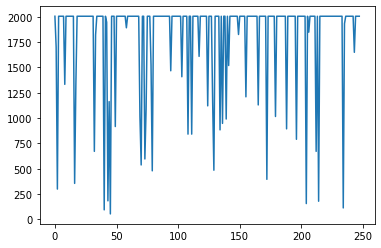

In [5]:
plt.plot(np.nansum(~np.isnan(price),axis=0))

<AxesSubplot:ylabel='Density'>

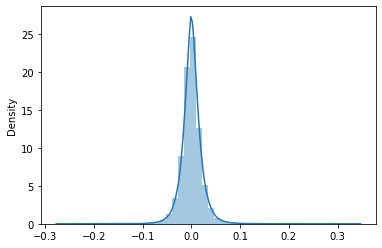

In [6]:
daily_return = price / price.shift(1) - 1.
# visualize the distribution
sns.distplot(daily_return)

In [7]:
# check the normality of daily return by KS test
rets = daily_return.values.flatten()
rets = rets[~np.isnan(rets)]
rets = (rets - np.mean(rets)) / np.std(rets)
kstest(rets, 'norm')
### p-value is close to zero
### reject the null hypothesis
### daily return doesn't follow a normal distribution

KstestResult(statistic=0.06148658772225102, pvalue=0.0)

<AxesSubplot:ylabel='Density'>

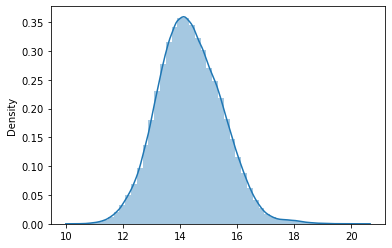

In [8]:
volume_1d = volume.values.flatten()
volume_1d[volume_1d == 0] = np.nan
sns.distplot(np.log(volume_1d))

In [9]:
volume_1d = volume_1d[~np.isnan(volume_1d)]
volume_1d = (volume_1d - np.mean(volume_1d)) / np.std(volume_1d)
kstest(volume_1d, 'norm')
### p-value is close to zero
### reject the null hypothesis
### log volume doesn't follow a normal distribution

KstestResult(statistic=0.3415464831018567, pvalue=0.0)

## Strategy & Backtest

In [4]:
from utils import Strategy, Backtest

In [5]:
strats = Strategy(price, volume)
backtest = Backtest(price)

#### Reverse / Momentum

In [12]:
signal_1_20 = strats.signal1(20)
backtest.get_result(signal_1_20)

,period return,annual return,annual volatility,sharpe ratio,max drawdown,max drawdown begin date,max drawdown end date,winning ratio
2013,7.49,82.06,10.96,7.49,-1.08,20130926,20131025,65.22
2014,-2.05,-20.63,6.86,-3.01,-1.94,20140106,20141210,52.00
2015,-2.47,-24.85,12.84,-1.94,-3.52,20150105,20151210,48.00
2016,-11.74,-118.29,10.08,-11.74,-11.43,20160104,20161226,20.00
2017,0.99,9.97,6.01,1.66,-1.34,20170302,20170428,56.00
2018,0.57,5.79,8.57,0.68,-1.51,20180417,20180601,48.00
2019,1.62,16.29,10.03,1.62,-2.45,20190802,20191101,52.00
2020,10.79,108.73,22.24,4.89,-3.43,20200521,20200716,68.00
2021,2.12,88.95,5.70,15.62,-0.11,20210119,20210202,66.67
total,21.22,26.87,11.85,2.27,-4.24,20150121,20151228,53.27


<AxesSubplot:ylabel='Density'>

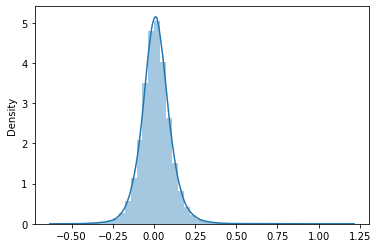

In [13]:
sns.distplot(signal_1_20)

In [14]:
signal_1_60 = strats.signal1(60)
backtest.get_result(signal_1_60)

,period return,annual return,annual volatility,sharpe ratio,max drawdown,max drawdown begin date,max drawdown end date,winning ratio
2013,4.56,60.46,9.24,6.54,-1.29,20130417,20130603,57.89
2014,-3.55,-35.75,6.37,-5.62,-2.96,20140121,20141210,48.00
2015,2.53,25.49,11.36,2.24,-3.05,20150120,20150430,60.00
2016,-9.66,-97.39,13.18,-7.39,-9.55,20160202,20161226,28.00
2017,6.66,67.14,8.69,7.72,-1.31,20170531,20170712,68.00
2018,4.08,41.08,9.58,4.29,-1.71,20180615,20180730,48.00
2019,2.82,28.47,9.70,2.93,-1.88,20190104,20190305,56.00
2020,10.22,103.02,19.04,5.41,-2.73,20200403,20200716,76.00
2021,3.28,137.66,6.43,21.39,0.00,20210104,20210104,100.00
total,17.66,22.82,11.18,2.04,-9.08,20160212,20170630,54.36


<AxesSubplot:ylabel='Density'>

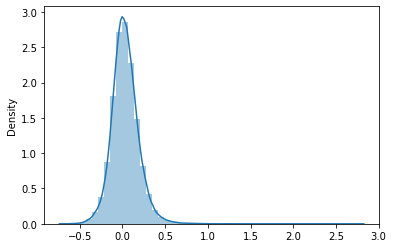

In [15]:
sns.distplot(signal_1_60)

In [16]:
signal_2_10_5 = strats.signal2(10,5)
backtest.get_result(signal_2_10_5)

,period return,annual return,annual volatility,sharpe ratio,max drawdown,max drawdown begin date,max drawdown end date,winning ratio
2013,4.62,48.55,7.99,6.08,-0.95,20130121,20130305,70.83
2014,-1.01,-10.21,6.46,-1.58,-1.47,20141111,20141210,44.00
2015,3.88,39.10,8.80,4.44,-1.77,20150105,20150304,56.00
2016,-5.00,-50.44,10.57,-4.77,-7.56,20160104,20160812,40.00
2017,-1.08,-10.85,6.14,-1.77,-1.41,20171010,20171221,48.00
2018,-0.15,-1.52,7.44,-0.20,-2.44,20180202,20181108,40.00
2019,-0.87,-8.80,11.40,-0.77,-4.39,20190620,20191216,44.00
2020,4.48,45.11,11.73,3.85,-2.72,20200507,20200818,56.00
2021,3.95,165.98,8.24,20.14,-0.19,20210304,20210318,83.33
total,27.67,34.86,8.68,4.02,-4.50,20190620,20200120,60.00


<AxesSubplot:ylabel='Density'>

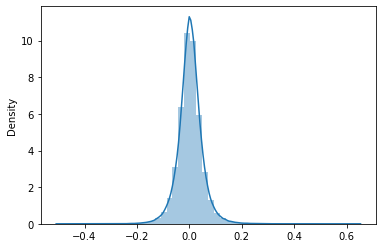

In [17]:
sns.distplot(signal_2_10_5)

In [18]:
signal_2_20_5 = strats.signal2(20,5)
backtest.get_result(signal_2_20_5)

,period return,annual return,annual volatility,sharpe ratio,max drawdown,max drawdown begin date,max drawdown end date,winning ratio
2013,7.75,84.89,8.61,9.86,-1.14,20130926,20131025,73.91
2014,-1.56,-15.70,5.95,-2.64,-1.72,20140417,20141210,48.00
2015,-0.14,-1.45,11.05,-0.13,-3.15,20150105,20150519,44.00
2016,-6.94,-69.97,12.27,-5.70,-7.34,20160202,20160812,32.00
2017,2.09,21.08,6.26,3.37,-1.07,20170331,20170727,64.00
2018,-0.11,-1.16,7.77,-0.15,-2.18,20180615,20181011,52.00
2019,0.13,1.35,11.28,0.12,-3.05,20190204,20190403,36.00
2020,5.16,51.97,12.59,4.13,-3.96,20200521,20200716,64.00
2021,2.28,95.81,7.84,12.22,-0.15,20210304,20210318,66.67
total,22.36,28.32,10.29,2.75,-3.34,20150121,20150603,56.78


<AxesSubplot:ylabel='Density'>

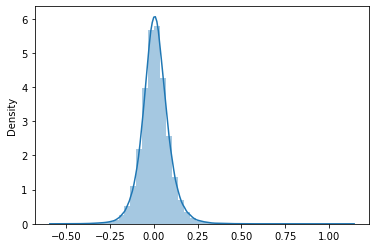

In [19]:
sns.distplot(signal_2_20_5)

#### Price Position
1. relative price position  
2. average relative price position

In [20]:
signal_3_10 = strats.signal3(10)
backtest.get_result(signal_3_10)

,period return,annual return,annual volatility,sharpe ratio,max drawdown,max drawdown begin date,max drawdown end date,winning ratio
2013,-5.83,-91.78,12.49,-7.35,-2.16,20130204,20130502,8.33
2014,-2.93,-38.83,5.99,-6.48,-0.45,20140106,20140121,20.00
2015,2.07,23.68,8.00,2.96,-0.83,20150105,20150203,44.00
2016,-7.70,-96.98,10.30,-9.42,-0.35,20160104,20160217,8.00
2017,-1.86,-21.30,9.32,-2.28,-0.61,20170104,20170119,40.00
2018,-2.65,-37.13,7.17,-5.18,-0.33,20180119,20180219,25.00
2019,-3.44,-41.24,9.80,-4.21,0.00,20190104,20190104,24.00
2020,7.85,94.23,21.64,4.36,-1.22,20200618,20200915,37.50
2021,1.07,45.09,4.01,11.25,-0.33,20210119,20210217,66.67
total,-16.96,-25.75,12.27,-2.10,-2.16,20130204,20130502,32.50


<AxesSubplot:ylabel='Density'>

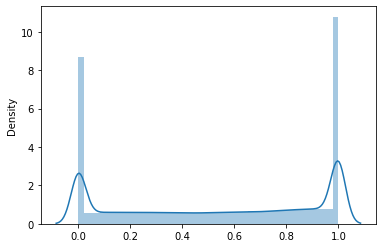

In [21]:
sns.distplot(signal_3_10) # too many 0s and 1s

<AxesSubplot:ylabel='Density'>

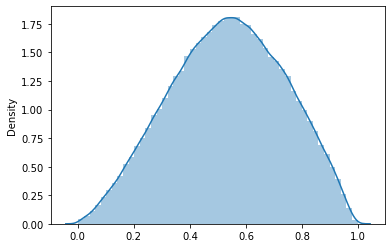

In [22]:
sns.distplot(signal_3_10.rolling(20).mean()) # try signal 4

In [23]:
signal_4_20 = strats.signal4(20)
backtest.get_result(signal_4_20)

,period return,annual return,annual volatility,sharpe ratio,max drawdown,max drawdown begin date,max drawdown end date,winning ratio
2013,-0.84,-8.87,5.16,-1.72,-1.57,20130827,20131125,45.83
2014,0.63,6.30,4.19,1.50,-0.59,20140403,20140502,48.00
2015,1.85,18.61,5.48,3.39,-1.35,20150120,20150519,60.00
2016,1.86,18.72,9.74,1.92,-2.19,20160428,20160713,64.00
2017,1.43,14.39,4.55,3.16,-0.68,20170428,20170727,52.00
2018,1.62,16.34,3.41,4.79,-0.86,20180119,20180518,56.00
2019,0.99,10.00,6.87,1.46,-1.99,20190121,20191017,60.00
2020,-5.04,-50.77,17.70,-2.87,-5.74,20200219,20201229,48.00
2021,-0.49,-20.53,3.85,-5.33,-0.34,20210104,20210202,33.33
total,-10.01,-12.62,6.16,-2.05,-10.50,20130827,20210315,40.50


<AxesSubplot:ylabel='Density'>

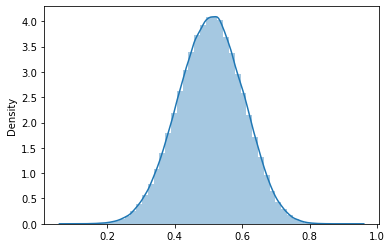

In [24]:
sns.distplot(signal_4_20)

#### High Moments of Return
1. volatility  
2. skew  
3. kurt

In [25]:
signal_5_20 = strats.signal5(20)
backtest.get_result(np.log(signal_5_20))

,period return,annual return,annual volatility,sharpe ratio,max drawdown,max drawdown begin date,max drawdown end date,winning ratio
2013,10.24,107.55,15.23,7.06,-1.38,20130520,20130603,66.67
2014,-1.83,-18.42,7.71,-2.39,-1.86,20140121,20140417,48.00
2015,0.15,1.47,9.02,0.16,-4.12,20150909,20151210,60.00
2016,7.19,72.48,18.40,3.94,-3.06,20160119,20160202,68.00
2017,2.18,21.93,5.07,4.32,-1.56,20170414,20170727,68.00
2018,-4.02,-40.54,10.46,-3.88,-5.54,20180119,20181207,48.00
2019,-4.10,-41.37,11.75,-3.52,-4.50,20190417,20191230,52.00
2020,1.24,12.54,14.01,0.90,-2.36,20200219,20200403,44.00
2021,3.06,128.52,10.05,12.79,-0.29,20210217,20210304,66.67
total,3.30,4.16,12.34,0.34,-13.57,20141217,20200501,53.00


<AxesSubplot:ylabel='Density'>

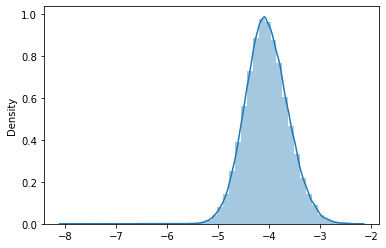

In [26]:
sns.distplot(np.log(signal_5_20))

In [27]:
signal_6_20 = strats.signal6(20)
backtest.get_result(signal_6_20)

,period return,annual return,annual volatility,sharpe ratio,max drawdown,max drawdown begin date,max drawdown end date,winning ratio
2013,4.29,45.04,6.04,7.46,-0.80,20131025,20131224,62.5
2014,1.28,12.88,4.36,2.95,-0.97,20140730,20141027,52.0
2015,-0.16,-1.59,4.84,-0.33,-1.20,20150812,20151126,48.0
2016,-5.19,-52.33,6.49,-8.07,-5.18,20160119,20161125,44.0
2017,0.85,8.59,4.44,1.93,-0.93,20170119,20170428,52.0
2018,-0.65,-6.51,4.91,-1.33,-1.83,20180104,20180518,52.0
2019,-2.06,-20.75,5.74,-3.62,-3.12,20190104,20190606,36.0
2020,3.34,33.66,11.47,2.93,-1.30,20200319,20200417,52.0
2021,1.84,77.15,3.76,20.50,0.00,20210104,20210104,100.0
total,8.50,10.71,6.26,1.71,-3.63,20150121,20170602,57.0


<AxesSubplot:ylabel='Density'>

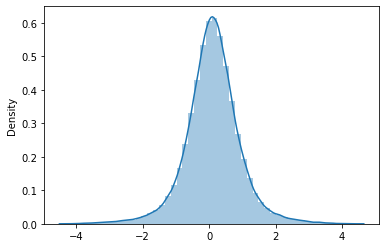

In [28]:
sns.distplot(signal_6_20)

In [29]:
signal_7_20 = strats.signal7(20)
backtest.get_result(np.log(signal_7_20))

,period return,annual return,annual volatility,sharpe ratio,max drawdown,max drawdown begin date,max drawdown end date,winning ratio
2013,2.13,22.40,9.47,2.36,-2.23,20130403,20130701,50.00
2014,1.62,16.33,3.61,4.52,-0.38,20140813,20140926,68.00
2015,1.23,12.40,5.53,2.24,-1.20,20150812,20150909,60.00
2016,-1.02,-10.32,5.07,-2.04,-2.86,20160302,20160728,52.00
2017,0.71,7.19,4.43,1.63,-0.45,20170119,20170414,48.00
2018,-0.84,-8.47,5.86,-1.44,-1.31,20181122,20181221,52.00
2019,-0.52,-5.27,6.37,-0.83,-1.61,20190104,20191101,52.00
2020,-0.38,-3.86,6.83,-0.57,-1.51,20200507,20200803,52.00
2021,0.38,16.10,4.42,3.64,-0.48,20210119,20210217,66.67
total,13.21,16.64,7.07,2.35,-2.59,20160725,20170602,53.50


<AxesSubplot:ylabel='Density'>

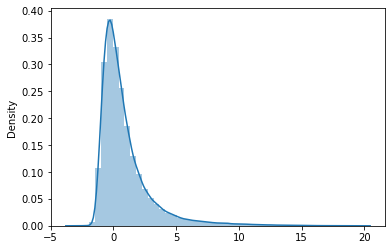

In [30]:
sns.distplot(signal_7_20) # seems like a lognormal distribution

#### Divergence

In [9]:
signal_8_20 = strats.signal8(20)
backtest.get_result(np.log(signal_8_20))

,period return,annual return,annual volatility,sharpe ratio,max drawdown,max drawdown begin date,max drawdown end date,winning ratio
2013,-2.35,-26.93,8.74,-3.08,-1.61,20130319,20130403,39.13
2014,2.74,27.62,6.58,4.20,-0.87,20140926,20141010,56.00
2015,-1.92,-19.37,18.65,-1.04,-4.21,20150519,20150826,44.00
2016,9.42,95.00,15.04,6.32,-2.09,20160518,20160615,72.00
2017,-0.92,-9.28,7.19,-1.29,-3.42,20170414,20171207,48.00
2018,-0.10,-0.99,8.35,-0.12,-3.13,20180305,20181122,48.00
2019,-0.21,-2.08,8.77,-0.24,-4.03,20190403,20190802,52.00
2020,-4.20,-42.30,10.00,-4.23,-3.76,20200106,20201030,20.00
2021,-2.11,-88.62,9.27,-9.56,-1.44,20210104,20210318,16.67
total,-5.34,-6.83,10.32,-0.66,-1.61,20130319,20130403,49.25


<AxesSubplot:ylabel='Density'>

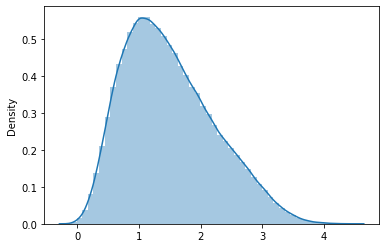

In [8]:
sns.distplot(np.log(signal_8_20))

#### Corr between price and volume

In [33]:
signal_9_20 = strats.signal9(20)
backtest.get_result(signal_9_20)

,period return,annual return,annual volatility,sharpe ratio,max drawdown,max drawdown begin date,max drawdown end date,winning ratio
2013,7.03,77.05,9.17,8.41,-0.86,20130910,20131111,69.57
2014,-1.10,-11.09,4.51,-2.46,-1.48,20140106,20140403,44.00
2015,-2.41,-24.30,6.18,-3.93,-3.31,20150105,20151210,32.00
2016,-3.48,-35.11,6.07,-5.78,-3.25,20160104,20161226,40.00
2017,1.67,16.81,6.40,2.63,-0.94,20171122,20171221,60.00
2018,-1.13,-11.39,5.01,-2.27,-1.54,20180417,20181221,44.00
2019,-1.87,-18.88,5.74,-3.29,-2.73,20190204,20191230,24.00
2020,3.14,31.67,7.57,4.18,-0.86,20200521,20200716,52.00
2021,1.01,42.41,7.22,5.87,-0.19,20210217,20210304,66.67
total,12.12,15.35,6.70,2.29,-3.99,20190204,20210301,51.26


<AxesSubplot:ylabel='Density'>

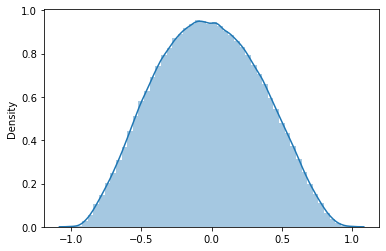

In [34]:
sns.distplot(signal_9_20)

#### Follow Smart Money

In [35]:
signal_10_20 = strats.signal10(20)
backtest.get_result(signal_10_20)

,period return,annual return,annual volatility,sharpe ratio,max drawdown,max drawdown begin date,max drawdown end date,winning ratio
2013,-1.09,-11.97,5.97,-2.00,-1.75,20130319,20130827,47.83
2014,0.61,6.20,3.89,1.59,-1.02,20140715,20141210,56.00
2015,-2.68,-27.01,5.69,-4.75,-3.24,20150318,20151210,40.00
2016,-2.11,-21.32,7.63,-2.79,-1.88,20160728,20161209,32.00
2017,0.76,7.66,3.61,2.12,-1.31,20170216,20170517,56.00
2018,-0.12,-1.20,3.77,-0.32,-0.58,20181025,20181108,44.00
2019,-1.72,-17.29,5.25,-3.29,-2.67,20190104,20190417,32.00
2020,4.86,48.94,12.72,3.85,-1.54,20200521,20200716,60.00
2021,0.48,20.26,4.36,4.65,-0.45,20210202,20210217,66.67
total,10.51,13.31,6.39,2.08,-3.52,20130319,20140806,54.77


<AxesSubplot:ylabel='Density'>

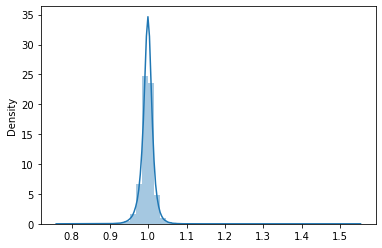

In [36]:
sns.distplot(signal_10_20)